*Importing the Libraries needed to run the explanatory data analysis and building the model to 
 to fit the data we have.*

In [2]:
import pandas as pd
import numpy as np
import random
import seaborn as sns 
import matplotlib.pyplot as plt 
import folium # type: ignore

from datetime import datetime, timedelta
from sklearn.tree import DecisionTreeClassifier
from folium.plugins import HeatMap # type: ignore
from math import radians, cos, sin, sqrt, atan2
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_predict
from math import radians, cos, sin, sqrt, atan2
from sklearn.metrics import accuracy_score, classification_report

*Reading the location data provided by the location API and create a datframe for the buisneses name, location, and catogry(type of buisness),*

In [3]:
# Define business categories and their specific locations
business_locations = [
    {
        "name": "Tim Horton's",
        "latitude": 49.26908,
        "longitude": -123.24872,
        "category": "Coffee Shop"
    },
    {
        "name": "Starbucks",
        "latitude": 49.26545,
        "longitude": -123.24991,
        "category": "Coffee Shop"
    },
    {
        "name": "LSK",
        "latitude": 49.26908,
        "longitude": -123.25514,
        "category": "Study Space"
    },
    {
        "name": "ESB",
        "latitude": 49.26335,
        "longitude": -123.24984,
        "category": "Study Space"
    },
    {
        "name": "ICICS",
        "latitude": 49.26118,
        "longitude": -123.24918,
        "category": "Study Space"
    },
    {
        "name": "Ponderosa",
        "latitude": 49.26417,
        "longitude": -123.25583,
        "category": "Student Residence"
    },
    {
        "name": "IKB", 
        "latitude": 49.26755, 
        "longitude": -123.25268, 
        "category": "Library"
    }, 
    {
       "name": "Rain or Shine",
        "latitude": 49.26632,
        "longitude": -123.24682,
        "category": "Icecream"
    }, 
    {
        "name": "Mercante",
        "latitude": 49.26376,
        "longitude": -123.25497,
        "category": "Italian Resturant"
    }
]

# Create DataFrame for businesses
businesses = pd.DataFrame(business_locations)

# Function to generate random timestamps
def random_time():
    return datetime.now() - timedelta(days=random.randint(0, 7), hours=random.randint(0, 23))

# Generate user locations within UBC's approximate boundaries
ubc_latitude_range = (49.2600, 49.2750)  # Approximate UBC latitude range
ubc_longitude_range = (-123.2600, -123.2450)  # Approximate UBC longitude range

# Create user DataFrame
users = pd.DataFrame({
    'user_id': [random.randint(1, 100) for _ in range(1000)],
    'latitude': np.random.uniform(ubc_latitude_range[0], ubc_latitude_range[1], 1000),
    'longitude': np.random.uniform(ubc_longitude_range[0], ubc_longitude_range[1], 1000),
    'timestamp': [random_time() for _ in range(1000)]
})

print(businesses.head())
print(users.head())

           name  latitude  longitude     category
0  Tim Horton's  49.26908 -123.24872  Coffee Shop
1     Starbucks  49.26545 -123.24991  Coffee Shop
2           LSK  49.26908 -123.25514  Study Space
3           ESB  49.26335 -123.24984  Study Space
4         ICICS  49.26118 -123.24918  Study Space
   user_id   latitude   longitude                  timestamp
0       57  49.262468 -123.259725 2024-09-30 09:06:40.075812
1       48  49.272490 -123.249966 2024-09-28 06:06:40.075812
2       21  49.262800 -123.248668 2024-10-04 21:06:40.075812
3        2  49.274898 -123.251291 2024-10-01 16:06:40.075812
4        7  49.261930 -123.253928 2024-09-30 07:06:40.075812


*Creating a density plot and a heatmap for the location of the users on a longitude latitude grid.*

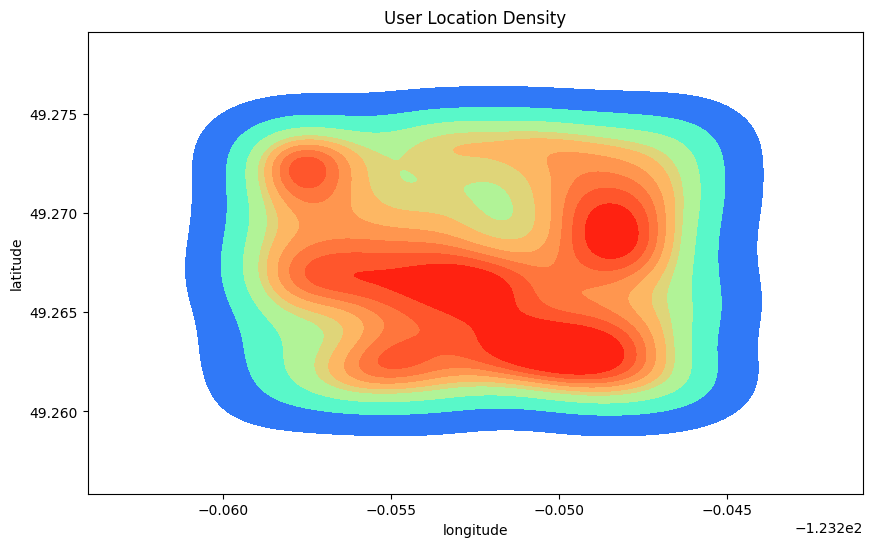

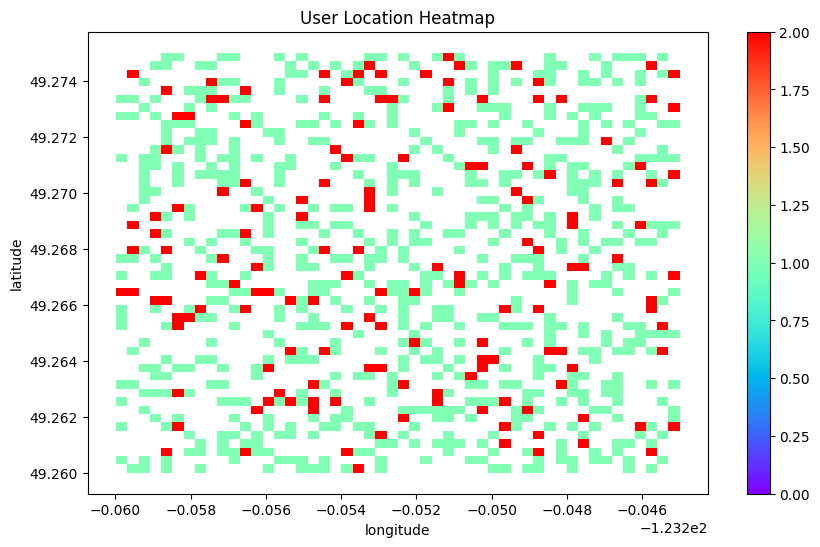

In [4]:
plt.figure(figsize=(10,6))
sns.kdeplot(x=users['longitude'], y=users['latitude'], cmap="rainbow", fill=True)
plt.title("User Location Density")
plt.show()

# Plot heatmap (density plot)
plt.figure(figsize=(10,6))
sns.histplot(x=users['longitude'], y=users['latitude'], bins=50, pmax=.9, cbar=True, cmap="rainbow")
plt.title("User Location Heatmap")
plt.show()

*Creating a heatmap for the users locations on UBC campus and visualizing the most visited locations.*

In [5]:
m_users = folium.Map(location=[49.25, -123.1], zoom_start=12)

# Add heatmap
heat_data = [[row['latitude'], row['longitude']] for index, row in users.iterrows()]
HeatMap(heat_data).add_to(m_users)

# Save map to an HTML file
m_users.save("user_heatmap.html")

m_users

*Using Haversine formula to calculate the distance(km) between the user and the potenial buisnesses that we are providing the service to.*

In [6]:
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of Earth in kilometers
    d_lat = radians(lat2 - lat1)
    d_lon = radians(lon2 - lon1)
    a = sin(d_lat/2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(d_lon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    return R * c 

user = users.iloc[0]
business = businesses.iloc[0]
distance = haversine(user['latitude'], user['longitude'], business['latitude'], business['longitude'])
print(f"Distance between user and business: {distance:.2f} km")

Distance between user and business: 1.09 km


*Creating a data frame that includes, besides the original user's feature, a fifth column which keeps track  of the number of visits the user made to a certain buisness location.*

In [7]:
user_business_visits = []

for i, user in users.iterrows():
    for j, business in businesses.iterrows():
        distance = haversine(user['latitude'], user['longitude'], business['latitude'], business['longitude'])
        if distance < 0.25: 
            user_business_visits.append([user['user_id'], business['name'], business['category'], user['timestamp']])

visits_df = pd.DataFrame(user_business_visits, columns=['user_id', 'name', 'category', 'timestamp'])

visits_df['visit_count'] = visits_df.groupby(['user_id', 'name'])['timestamp'].transform('count')
visits_df = visits_df.drop_duplicates()

print(visits_df.head())

   user_id       name           category                  timestamp  \
0       21        ESB        Study Space 2024-10-04 21:06:40.075812   
1       21      ICICS        Study Space 2024-10-04 21:06:40.075812   
2        7   Mercante  Italian Resturant 2024-09-30 07:06:40.075812   
3       99      ICICS        Study Space 2024-10-05 11:06:40.075812   
4       11  Ponderosa  Student Residence 2024-09-29 21:06:40.075812   

   visit_count  
0            2  
1            2  
2            1  
3            2  
4            1  


*Blinding the user and buisnesses data frames together and grouping each user based on the buisbesses they visit/visited and then get the number of visits the user made to each buisness. creating a feature that provide us with the number of visits that the users made, in the past 3 weeks to the list of buisnesses we have.*

In [8]:
visits_df['future_visit'] = visits_df.groupby(['user_id', 'name'])['visit_count'].shift(-1) 
visits_df['future_visit'] = (visits_df['future_visit'] > 0).astype(int) 

visits_df = visits_df.dropna(subset=['future_visit'])

visits_df['past_week_1'] = visits_df.groupby(['user_id', 'name'])['visit_count'].shift(1).fillna(0)
visits_df['past_week_2'] = visits_df.groupby(['user_id', 'name'])['visit_count'].shift(2).fillna(0)
visits_df['past_week_3'] = visits_df.groupby(['user_id', 'name'])['visit_count'].shift(3).fillna(0)

visits_df.head()

,user_id,name,category,timestamp,visit_count,future_visit,past_week_1,past_week_2,past_week_3
0,21,ESB,Study Space,2024-10-04 21:06:40.075812,2,1,0.0,0.0,0.0
1,21,ICICS,Study Space,2024-10-04 21:06:40.075812,2,1,0.0,0.0,0.0
2,7,Mercante,Italian Resturant,2024-09-30 07:06:40.075812,1,0,0.0,0.0,0.0
3,99,ICICS,Study Space,2024-10-05 11:06:40.075812,2,1,0.0,0.0,0.0
4,11,Ponderosa,Student Residence,2024-09-29 21:06:40.075812,1,0,0.0,0.0,0.0


*Creating two variables X and Y. X is the input variables to the model, and y is the response. predicting the *

In [9]:
X = visits_df[['past_week_1', 'past_week_2', 'past_week_3']]  
y = visits_df['future_visit']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = DecisionTreeClassifier() 
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(classification_report(y_test, y_pred))

Accuracy: 0.70
              precision    recall  f1-score   support

           0       0.67      0.99      0.80       173
           1       0.96      0.25      0.39       110

    accuracy                           0.70       283
   macro avg       0.82      0.62      0.60       283
weighted avg       0.79      0.70      0.64       283



In [10]:
user_category = visits_df.groupby(['user_id', 'category'])['visit_count'].sum().reset_index()

user_favorites = user_category.loc[user_category.groupby('user_id')['visit_count'].idxmax()]

user_favorites['user_category'] = user_favorites['category'].apply(lambda x: f"{x} Lover")

print(user_favorites[['user_id', 'user_category']])

     user_id            user_category
0          1        Coffee Shop Lover
6          2        Study Space Lover
9          3        Study Space Lover
10         4        Coffee Shop Lover
13         5        Coffee Shop Lover
..       ...                      ...
428       95        Study Space Lover
432       96        Study Space Lover
433       97        Coffee Shop Lover
441       98  Student Residence Lover
447       99        Study Space Lover

[99 rows x 2 columns]


*Visualizing users' prefrences for all buisnesses' catogries. allowing buisnesses to visually analyis 
the most visited buisnesses location.*

C:\Users\alhus\AppData\Local\Temp\ipykernel_19332\3589538279.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_counts.index, y=category_counts.values, palette='viridis')


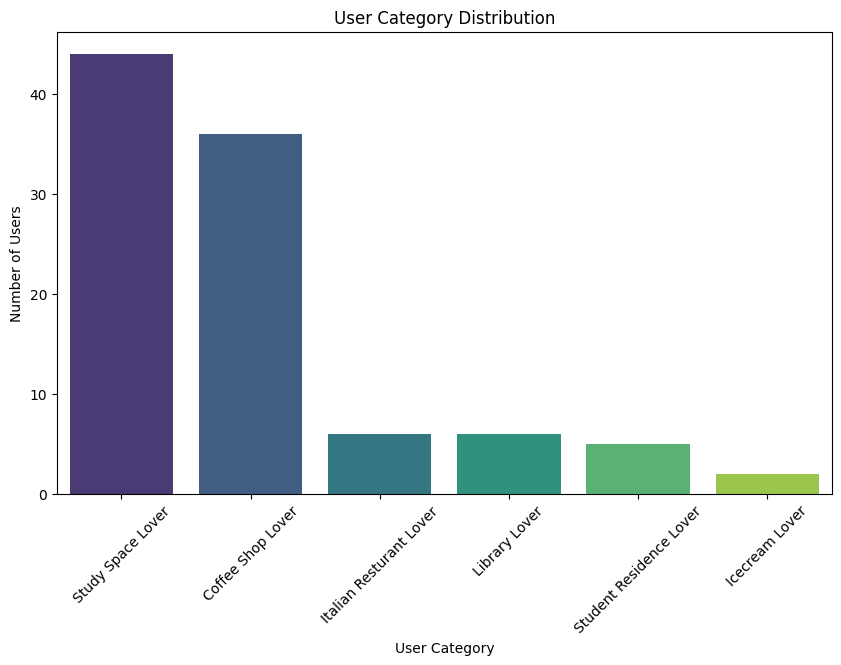

In [11]:
category_counts = user_favorites['user_category'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=category_counts.index, y=category_counts.values, palette='viridis')
plt.xticks(rotation=45)
plt.xlabel('User Category')
plt.ylabel('Number of Users')
plt.title('User Category Distribution')
plt.show()